### ****Проведение анализа поведения пользователей мобильной игры****
### Задачи:
1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.


In [83]:
import pandas as pd
import matplotlib.pyplot as plt
events = pd.read_csv('data/7_4_Events.csv', sep=',')
purchase = pd.read_csv('data/purchase.csv', sep=',')

#Проведем подготовку данных для анализа
#Определим все действия пользователей, которые прошли регистрацию в 2018 году
mask1=events['start_time'] < '2019-01-01'
mask2=events['start_time'] >= '2018-01-01'
mask3=events['event_type'] == 'registration'
users_2018 = events[mask1 & mask2 & mask3]['user_id'].to_list()
events_df = events[events['user_id'].isin(users_2018)].copy()
purchase_df = purchase[purchase['user_id'].isin(users_2018)].copy()

#Переводим тип данных столбцов с датой в datetime
purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime'], yearfirst=True)
events_df['start_time'] = pd.to_datetime(events_df['start_time'], yearfirst=True)

#Объединим датафреймы для удобства проведения анализа
purchase_df['event_type'] = 'purchase' 
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})
total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

### Задача 1. Определить, насколько обучение сокращает время прохождения этапов игры.
Должна быть разница в поведении групп, которые проходят и не проходят обучение. Влияет ли обучение на скорость прохождения других этапов игры? Необходимо сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение.

event_type,tutorial_start_time,tutorial_finish_time,level_choice_time,pack_choice_time,purchase_time,reg_purchase_time,reg_level_choice_time
tutorial_type,,,,,,,
finished,4.52,0.2,2.33,0.09,89.30,96.50,7.09
not_finished,5.42,NaN,2.79,0.08,93.25,101.55,8.22
not_started,NaN,NaN,5.26,0.09,100.83,105.10,5.26


''

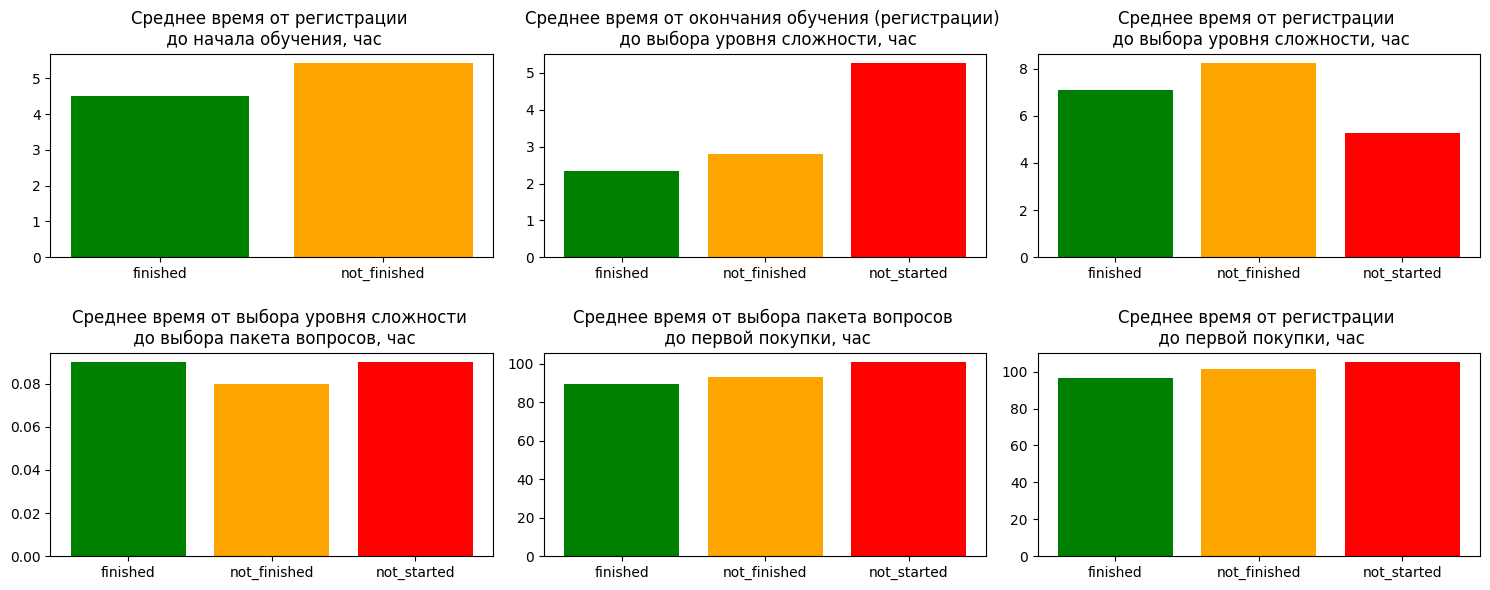

In [84]:
#Построим сводную таблицу с датами начала каждого этапа игры
pivot = total_events_df.pivot_table(values='start_time', index='user_id', columns='event_type', aggfunc='min')

#Создадим функцию для определения групп пользователей, окончивших, не окончивших и не начинавших обучение
def tutorial_group (raw):
    if raw['tutorial_start'] is pd.NaT: 
        return 'not_started'
    elif raw['tutorial_finish'] is not pd.NaT: 
        return 'finished'
    else: 
        return 'not_finished'

#Добавим столбец с меткой группы окончивших, не окончивших и не начинавших обучение пользователей
pivot['tutorial_type'] = pivot.apply(tutorial_group, axis=1)

#Определим время от регистрации до начала обучения
pivot['tutorial_start_time'] = pivot['tutorial_start'] - pivot['registration']

#Определим время от начала обучения до конца обучения
pivot['tutorial_finish_time'] = pivot['tutorial_finish'] - pivot['tutorial_start']

#Создадим функцию для определения времени от последнего пройденного этапа до выбора уровня сложности
def time_level_choice(raw):
    if raw['tutorial_finish'] is not pd.NaT: 
        return raw['level_choice'] - raw['tutorial_finish']
    elif raw['tutorial_start'] is pd.NaT: 
        return raw['level_choice'] - raw['registration']
    else: 
        return raw['level_choice'] - raw['tutorial_start']

#Определим время от последнего пройденного этапа до выбора уровня сложности
pivot['level_choice_time'] = pivot.apply(time_level_choice, axis=1)

#Определим время от выбора уровня сложности до выбора пакета вопросов
pivot['pack_choice_time'] = pivot['pack_choice']-pivot['level_choice']

#Определим время от выбора пакета вопросов до первой покупки
pivot['purchase_time'] = pivot['purchase']-pivot['pack_choice']

#Определим время от регистрации до первой покупки
pivot['reg_purchase_time'] = pivot['purchase']-pivot['registration']

#Определим время от регистрации до выбора уровня сложности
pivot['reg_level_choice_time'] = pivot['level_choice']-pivot['registration']

#Определим среднее время прохождения этапов для  групп пользователей, окончивших, не окончивших и не начинавших обучение
pivot_group=pivot.groupby(by='tutorial_type')[['tutorial_start_time', 'tutorial_finish_time', 
                                               'level_choice_time', 'pack_choice_time', 'purchase_time', 
                                               'reg_purchase_time', 'reg_level_choice_time']].mean()

#Приведем значения времени прохождения разных этапов к часам
pivot_group=pivot_group.apply(lambda raw: round(raw/pd.Timedelta('1 hour'),2))

display(pivot_group)

#Построим столбчатые диаграммы для наглядного отображения полученных результатов анализа
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
axes[0][0].bar(x=pivot_group.index,
    height=pivot_group['tutorial_start_time'],
    color=['green', 'orange', 'red'],
)
axes[0][0].set_title('Среднее время от регистрации \n до начала обучения, час')

axes[0][1].bar(x=pivot_group.index,
    height=pivot_group['level_choice_time'],
    color=['green', 'orange', 'red'],
)
axes[0][1].set_title('Среднее время от окончания обучения (регистрации) \n до выбора уровня сложности, час')

axes[0][2].bar(x=pivot_group.index,
    height=pivot_group['reg_level_choice_time'],
    color=['green', 'orange', 'red'],
)
axes[0][2].set_title('Среднее время от регистрации \n до выбора уровня сложности, час')

axes[1][0].bar(x=pivot_group.index,
    height=pivot_group['pack_choice_time'],
    color=['green', 'orange', 'red'],
)
axes[1][0].set_title('Среднее время от выбора уровня сложности \n до выбора пакета вопросов, час')

axes[1][1].bar(x=pivot_group.index,
    height=pivot_group['purchase_time'],
    color=['green', 'orange', 'red'],
)
axes[1][1].set_title('Среднее время от выбора пакета вопросов \n до первой покупки, час')

axes[1][2].bar(x=pivot_group.index,
    height=pivot_group['reg_purchase_time'],
    color=['green', 'orange', 'red'],
)
axes[1][2].set_title('Среднее время от регистрации \n до первой покупки, час')

fig.tight_layout (h_pad= 2 )
,


#### Выводы по задаче 1.
Можно сделать вывод, что время прохождения разных этапов для групп пользователей закончивших и не закончивших обучение отличается незначительно. Время от регистрации до первой покупки у группы пользователей не закончивших обучение в среднем больше на 5 часов по сравнению с группой пользователей, закончивших обучение. 
Для группы пользователей, не проходивших обучение, время от регистрации до первой покупки в среднем больше на 8,6 часа по сравнению с группой пользоваталей, закончивших обучение.  
Пользователи, прошедшие обучение, быстрее совершают первую покупку. 

### Задача 2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 

,users,purchases,CR
tutorial_attemps,,,
0,8068,22,0.3
1,9103,1207,13.3
2,1589,218,13.7
3,427,51,11.9
4,221,30,13.6
5,109,16,14.7
6,116,14,12.1
7,94,12,12.8
8,86,13,15.1


''

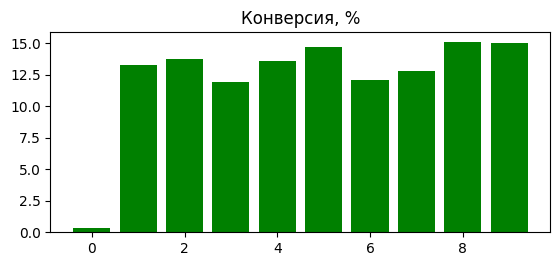

In [85]:
#Посчитаем количество попыток обучения и количество оплат для каждого пользвателя
tutorial_count = total_events_df.groupby(by='user_id')[['tutorial_id', 'purchase_id']].nunique()

#Сгруппируем таблицу и посчитаем, сколько пользователей и оплат приходится на каждую группу количества попыток обучения
tutorial_attemps = tutorial_count.groupby(by='tutorial_id').count()
tutorial_attemps = tutorial_attemps.rename(columns={'purchase_id': 'users'})
tutorial_attemps['purchases'] = tutorial_count.groupby(by='tutorial_id').sum()
tutorial_attemps.index.names = ['tutorial_attemps']
tutorial_attemps['CR'] = round(tutorial_attemps['purchases']/tutorial_attemps['users']*100,1)
display(tutorial_attemps)


#Построим столбчатые диаграммы для наглядного отображения полученных результатов анализа
fig = plt.figure( figsize=(5, 2))
axes = fig.add_axes([0, 0, 1, 1])

axes.bar(x=tutorial_attemps.index,
    height=tutorial_attemps['CR'],
    color=['green'],
)
axes.set_title('Конверсия, %')
,

#### Выводы по задаче 2
Из приведенной выше таблицы видно, что конверсия из пользователей, не начинавших обучение, в клиенты составляет всего 0,3%. Для всех остальных групп пользователей, начинавших обучение, конверсия составляет в среднем 13,6%. Количество начатых обучений незначиьельно влияет на вероятность оплаты: наибольшая конверсия у группы с 8 начатыми обучениями (15,1%), наименьшая конверсия у группы с 3 начатыми обучениями (11,9%).

### Задача 3. Определить, насколько прозрачен процесс взаимодействия с игрой.
Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. Нужно посчитать количество уникальных пользователей, у которых обучение происходило после выбора уровня сложности.

'Количество пользователей, вернувшихся к прохождению обучения после выбора уровня сложности составляет 1386 человек'

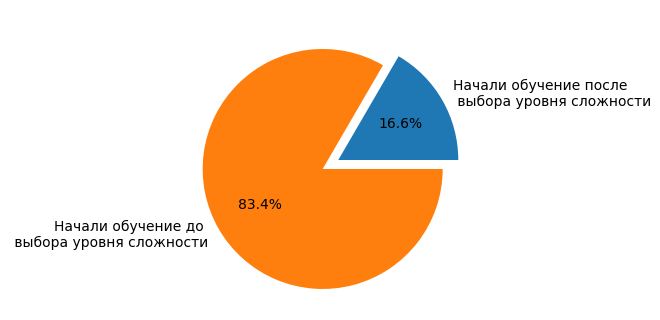

In [86]:
#Рассчитаем количество пользователей, прошедших этап выбор уровня сложности
users_level_choice = total_events_df[total_events_df['event_type']=='level_choice']['user_id'].count()

#Создадим сводную таблицу для расчета времени выбора уровня сложности и прохождения обучения
pivot_users = total_events_df.pivot_table(values='start_time', index='user_id', columns='event_type', aggfunc='max')

#Посчитаем количество пользователей, начавших обучение после выбора уровня сложности
users_tutor_after_level = pivot_users[pivot_users['level_choice'] < pivot_users['tutorial_start']]['level_choice'].count()
display( f'Количество пользователей, вернувшихся к прохождению обучения после выбора уровня сложности составляет {users_tutor_after_level} человек')

#Построим круговую диаграмму для наглядного отображения результатов
fig = plt.figure(figsize=(3, 3))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    [users_tutor_after_level, users_level_choice - users_tutor_after_level],
    labels=['Начали обучение после \n выбора уровня сложности', 'Начали обучение до \n выбора уровня сложности'],
    autopct='%.1f%%',
    explode = [0, 0.15]
);

#### Выводы по задаче 3.
После выбора уровня сложности 16,6% пользователей (1386 человек) вернулись к прохождению обучения. Это свидетельствует о том, что процесс взаимодействия с игрой непрозрачен.

### Общие выводы.
Необходимо стимулировать прохождение обучения пользователями, поскольку это снижает время до первой покупки в среднем на 8,6 часа и увеличивает конверсию пользователей в клиенты в среднем на 13,6%. 